In [872]:
# import libraries 
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [873]:
# load video as a list of frames 
video_file_path = 'input_videos/dubaidrive.mov'
video = cv2.VideoCapture(video_file_path)
frames = []
valid, frame = video.read()
while valid: 
    frames.append(frame)
    valid, frame = video.read()
    
# print number of frames in video
print('Video consists of {} frames'.format(len(frames)))

Video consists of 721 frames


In [874]:
# select first frame to work with 
processed_frame = frames[0]

Grayscaled frame


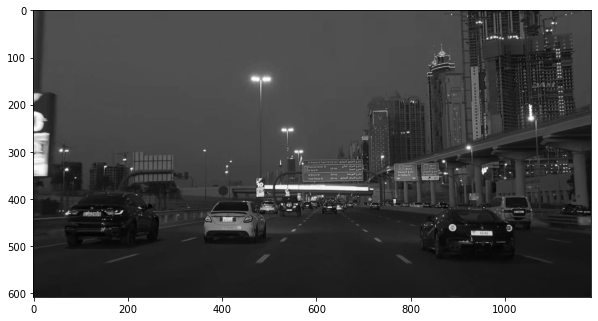

In [875]:
# grayscale a frame
def grayscale_frame(frame):
    grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    return grayscale_frame

# show grayscaled frame
print('Grayscaled frame')
processed_frame = detect_edges(processed_frame)
plt.figure(figsize=(10, 10))
plt.imshow(processed_frame, cmap="gray")

Masked frame


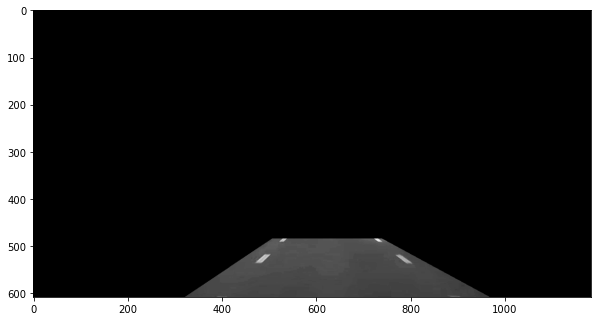

In [876]:
# mask the image based on region of interest 
def mask_region_of_interest(frame):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    polygons = np.array([ 
        [(frame_width * 3 // 11, frame_height), (frame_width * 9 // 11, frame_height), (frame_width * 5 // 8, frame_height // 5 * 4), (frame_width * 3 // 7, frame_height // 5 * 4)] 
    ])
    mask = np.zeros_like(frame) 
    cv2.fillPoly(mask, polygons, 255)
    masked_frame = cv2.bitwise_and(frame, mask)
    return masked_frame

# show masked frame
print('Masked frame')
processed_frame = mask_region_of_interest(processed_frame)
plt.figure(figsize=(10, 10))
plt.imshow(processed_frame, cmap="gray")

Thresholded frame


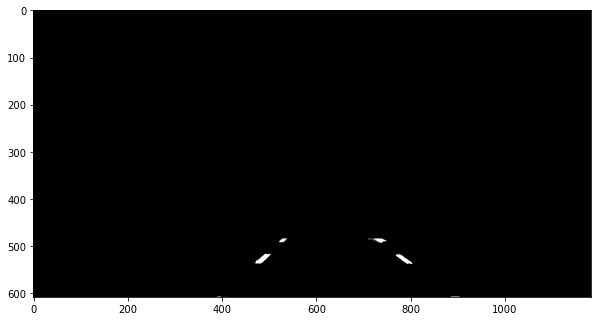

In [877]:
# apply frame thresholding 
def threshold_frame(frame):
    ret, thresh = cv2.threshold(frame, 40, 145, cv2.THRESH_BINARY)
    return thresh
    
# show thresholded frame 
print('Thresholded frame')
processed_frame = threshold_frame(processed_frame)
plt.figure(figsize=(10, 10))
plt.imshow(processed_frame, cmap="gray")

In [878]:
# create lane marker points
def create_lane_marker_points(frame, params):
    slope, intercept = params[0], params[1]
    y1 = frame.shape[0]
    y2 = int(y1 * 4 / 5)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [879]:
# find lane lines
def find_lane_lines(frame, lines):
    left_lane_fit, right_lane_fit = [], []
    if lines is None: 
        return None
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope, intercept = parameters[0], parameters[1]
        if slope < 0: 
            left_lane_fit.append((slope, intercept))
        else: 
            right_lane_fit.append((slope, intercept))
    left_lane_avgfit = np.average(left_lane_fit, axis=0)
    if np.any(np.isnan(left_lane_avgfit)): 
        return None
    left_lane_line = create_lane_marker_points(frame, left_lane_avgfit)
    right_lane_avgfit = np.average(right_lane_fit, axis=0)
    if np.any(np.isnan(right_lane_avgfit)): 
        return None
    right_lane_line = create_lane_marker_points(frame, right_lane_avgfit)
    return np.array([left_lane_line, right_lane_line])

In [880]:
# draw lane lines 
def draw_lane_lines(frame, lane_lines): 
    lane_line_frame = np.zeros_like(frame)
    if lane_lines is not None: 
        for x1, y1, x2, y2 in lane_lines:
            try: 
                cv2.line(lane_line_frame, (x1, y1), (x2, y2), (0, 255, 0), 10)
            except: 
                return None
    return lane_line_frame

In [881]:
# perform lane detection on video frames
lane_detected_frames = []
for frame in frames: 
    grayscaled_frame = grayscale_frame(frame)
    masked_frame = mask_region_of_interest(grayscaled_frame)
    thresholded_frame = threshold_frame(masked_frame)
    detected_lines = cv2.HoughLinesP(thresholded_frame, 2, np.pi / 180, 100, np.array([]), minLineLength = 10, maxLineGap = 5)
    lane_lines = find_lane_lines(frame, detected_lines)
    if lane_lines is None: 
        lane_detected_frames.append(frame)
        continue
    annotated_frame = draw_lane_lines(frame, lane_lines)
    if annotated_frame is None: 
        lane_detected_frames.append(frame)
        continue
    combined_frame = cv2.addWeighted(frame, 0.8, annotated_frame, 1, 1)
    lane_detected_frames.append(combined_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

Lanes detected in frame
721


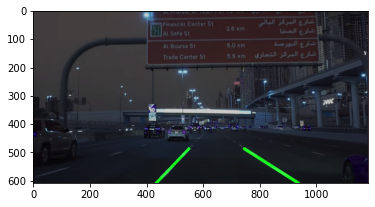

In [882]:
# show lanes detected in a frame
print('Lanes detected in frame')
print(len(lane_detected_frames))
plt.imshow(lane_detected_frames[300])

In [884]:
# compile frames into video and play 
height, width, layers = lane_detected_frames[0].shape
size = (width, height)
fps = 60
output_file = 'output.mp4'
output_video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for frame in lane_detected_frames: 
    output_video.write(frame)